In [1]:
import numpy as np 
from darkspirals.disc import Disc
import numpy as np
import matplotlib.pyplot as plt
from darkspirals.distribution_function.compute_df import compute_df_from_orbits, compute_df_from_actions
from darkspirals.orbit_util import integrate_single_orbit, sample_sag_orbit, satellite_vertical_force
from darkspirals.substructure.halo_util import sample_dwarf_galaxy_potential_nfw
from galpy.potential import MovingObjectPotential, turn_physical_off
from galpy.potential import toVerticalPotential
from galpy.potential import MWPotential2014
from darkspirals.substructure.realization import SubstructureRealization
from galpy.potential import toVerticalPotential
import astropy.units as apu 
from galpy.orbit import Orbit
import galpy
from galpy.actionAngle.actionAngleVertical import actionAngleVertical
from galpy.potential import evaluatezforces, NFWPotential
from scipy.integrate import simps

z_min_max = 1.0 
vz_min_max = 60 
phase_space_resolution = 100
z = np.linspace(-z_min_max,z_min_max,phase_space_resolution)
vz = np.linspace(-vz_min_max, vz_min_max, phase_space_resolution)
galactic_potential = MWPotential2014
time_Gyr = np.linspace(0.0, -1., 1000) * apu.Gyr

disc = Disc(galactic_potential, galactic_potential, z_min_max, vz_min_max, phase_space_resolution, 
            time_Gyr, parallelize_action_angle_computation=True, compute_upfront=True)

A new version of galpy (1.10.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


/Users/danielgilman/anaconda3/lib/python3.8/site-packages/galpy/actionAngle/actionAngleVertical.py:242: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  / integrate.quad(



### set up a perturber orbit

[[ 3.30369325 -0.19814571  0.41738837  3.63723971  0.26314343  0.26578838]]


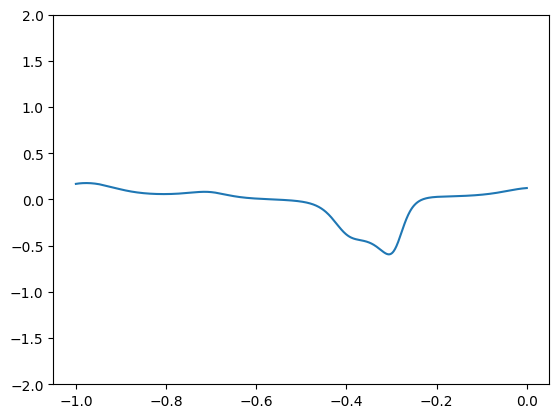

In [2]:
r_min = 2
np.random.seed(1)
realization = SubstructureRealization.withDistanceCut(disc, norm=0.0, r_min=r_min, 
                                                      num_halos_scale=1.0, 
                     
                                                      m_low=10**6.7, 
                                                      m_high=10**8.0, 
                                                      t_max=-1.2)
realization.add_dwarf_galaxies(add_orbit_uncertainties=True, 
                               tidal_stripping=False,
                                       include_dwarf_list=['Willman I'], 
                               log10_dsphr_masses={'Willman I': 9.})
f = realization.orbits[0].force_exerted(disc, physical_units=True)
plt.ylim(-2, 2)
print(realization.orbits[0].vxvv)
plt.plot(time_Gyr, f); plt.show()

perturber_orbit = realization.orbits[0]
perturber_potential = realization.potentials[0]

exact_potential = MWPotential2014 + MovingObjectPotential(perturber_orbit, 
                                                          pot=perturber_potential)
exact_potential_vertical = toVerticalPotential(exact_potential,
                                                disc.r_over_r0, phi=0)
turn_physical_off(exact_potential_vertical)
equilibrium_potential_vertical = toVerticalPotential(MWPotential2014, disc.r_over_r0)
turn_physical_off(equilibrium_potential_vertical)

### Do the exact calculation 

In [3]:
ro = 8.0
vo = 220.0
coordinates = np.array(np.meshgrid(disc.z_units_internal, disc.vz_units_internal)).T

idx1, idx2 = 25, 20
z_internal, vz_internal = coordinates[idx1,idx2,:]
z_phys, vz_phys = z_internal * ro, vz_internal * vo
print('coordinates: ', z_phys, vz_phys)

initial_action, intial_angle, intial_freq = disc.action_angle_interp((z_phys, vz_phys))
print('intial action/angle/freq: ', initial_action, intial_angle, intial_freq)

coordinates:  -0.4949494949494949 -35.75757575757576
intial action/angle/freq:  0.012140206963280284 3.6008511407415025 1.3732973592204507


In [4]:
perturbed_orbit = Orbit(vxvv=[z_internal, vz_internal])
perturbed_orbit.integrate(disc.time_internal_eval, pot=exact_potential_vertical)
aav = actionAngleVertical(pot=exact_potential_vertical)
jz_true, freq_true, theta_true = aav.actionsFreqsAngles(perturbed_orbit.x(disc.time_internal_eval), 
                                               perturbed_orbit.vx(disc.time_internal_eval))

unperturbed_orbit = Orbit(vxvv=[z_internal, vz_internal])
unperturbed_orbit.integrate(disc.time_internal_eval, pot=equilibrium_potential_vertical)
aav_eq = actionAngleVertical(pot=equilibrium_potential_vertical)
jz_eq, freq_eq, theta_eq = aav_eq.actionsFreqsAngles(unperturbed_orbit.x(disc.time_internal_eval), 
                                               unperturbed_orbit.vx(disc.time_internal_eval))


/Users/danielgilman/anaconda3/lib/python3.8/site-packages/galpy/actionAngle/actionAngleVertical.py:258: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  angle[ii] = integrate.quad(



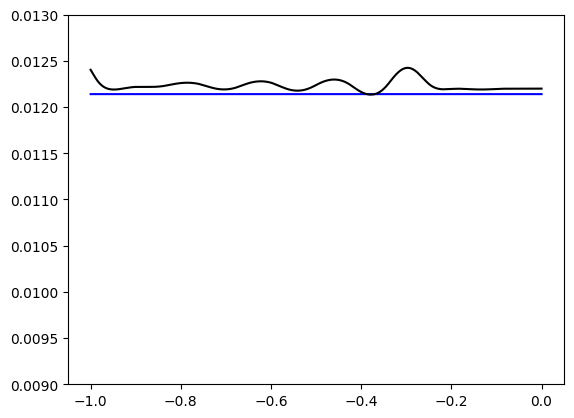

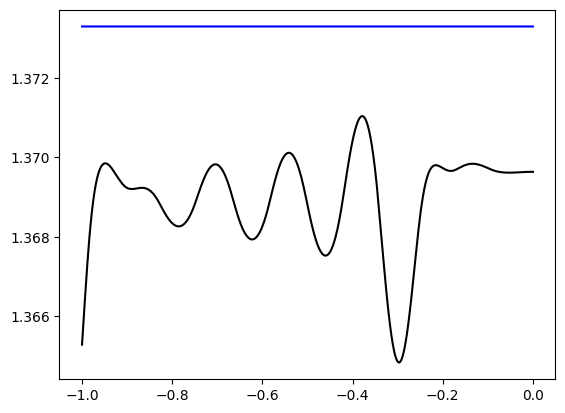

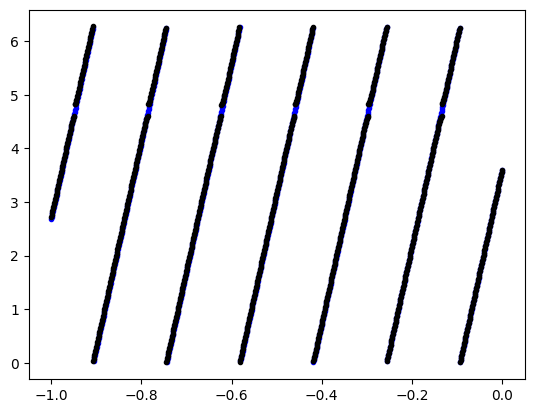

In [5]:
plt.plot(time_Gyr, jz_eq, color='b')
plt.plot(time_Gyr, jz_true, color='k')
plt.ylim(0.009, 0.013); plt.show()

plt.plot(time_Gyr, freq_eq, color='b')
plt.plot(time_Gyr, freq_true, color='k'); plt.show()

plt.plot(time_Gyr, theta_eq, '.', color='b')
plt.plot(time_Gyr, theta_true, '.', color='k'); plt.show()

### Compare results

In [6]:
vcirc = galpy.potential.vcirc(disc.galactic_potential, disc.r_over_r0)
circ_freq_solar_orbit = vcirc / disc.r_over_r0
print('circ_freq_solar_orbit: ', circ_freq_solar_orbit)
x_solar = disc.r_over_r0 * np.cos(circ_freq_solar_orbit * disc.time_internal_eval)
y_solar = disc.r_over_r0 * np.sin(circ_freq_solar_orbit * disc.time_internal_eval)

z_coord = unperturbed_orbit.x(disc.time_internal_eval)
dx = x_solar - perturber_orbit.x(disc.time_internal_eval)
dy = y_solar - perturber_orbit.y(disc.time_internal_eval)
dz = z_coord - perturber_orbit.z(disc.time_internal_eval)
dR = np.sqrt(dx ** 2. + dy ** 2.)
turn_physical_off(perturber_potential)
force = evaluatezforces(perturber_potential, R=dR, z=dz)
integrand = force * unperturbed_orbit.vx(disc.time_internal_eval) / intial_freq
deltaJ_approx = simps(integrand, disc.time_internal_eval)

f = disc.compute_satellite_forces([perturber_orbit], [perturber_potential])
deltaJ_code = disc.compute_deltaJ_from_forces(f)

starting_difference = jz_true[0] - jz_eq[0]
deltaJ_true = jz_true[0] - jz_true[-1]

print('this notebook (x10000): ', 10000*deltaJ_approx)
print('code (x10000): ', 10000*deltaJ_code[0][idx1, idx2])
print('exact (x10000): ', 10000*deltaJ_true)
print('difference %: ', 100*(deltaJ_code[0][idx1, idx2]/deltaJ_true-1))

circ_freq_solar_orbit:  0.8338427207846085
this notebook (x10000):  -0.13405889318994021
code (x10000):  -0.13405889318994021
exact (x10000):  -2.0374050432116557
difference %:  -93.4201157675247


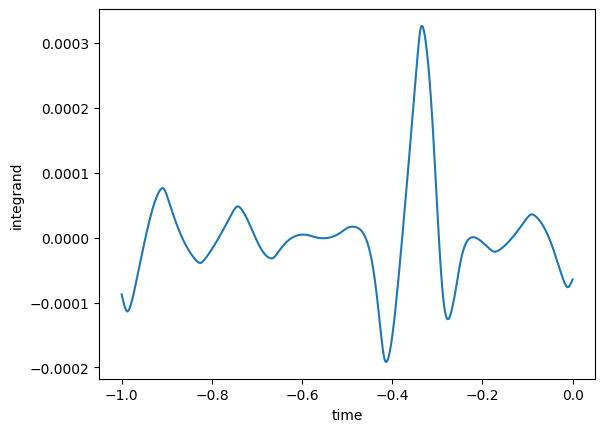

Text(0, 0.5, 'deltaJ (t)')

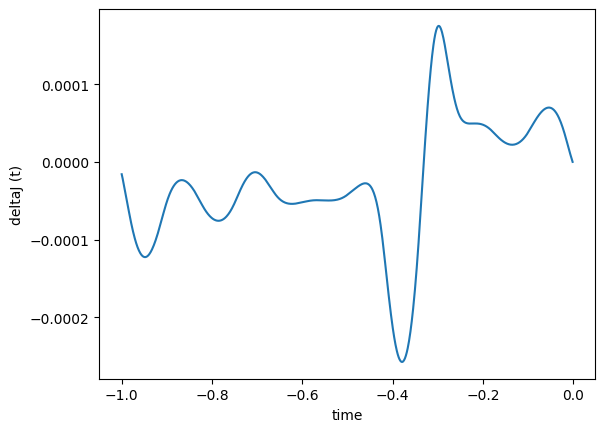

In [15]:
deltaJ_vs_time = []
plt.plot(time_Gyr, integrand)
plt.xlabel('time')
plt.ylabel('integrand')
plt.show()

for i in range(1, len(time_Gyr)):
    deltaJ_vs_time.append(simps(integrand[0:i],x=disc.time_internal_eval[0:i]))
plt.plot(time_Gyr[1:], deltaJ_vs_time)
plt.xlabel('time')
plt.ylabel('deltaJ (t)')